## AIM: Utilize requests & bs4 to scrape data off of the Fangraphs page containing season-level data for pitchers from 2002 to 2019.

***

In [33]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import time
from scipy.stats import percentileofscore
import numpy as np
import matplotlib.pyplot as plt

In [51]:
# See warnings just once
import warnings
warnings.filterwarnings(action='once')

***
### Webscraping

In [5]:
# Don't need to f-string loop this, all column headers will remain the same
# Page source
source = requests.get('https://www.fangraphs.com/leaders.aspx?pos=all&stats=sta&lg=all&qual=y&type=c,4,5,11,7,8,13,-1,36,37,40,43,44,48,51,-1,6,45,62,-1,59,3,21,47,49,60,75,77,79,81,83,85,87,76,41,42&season=2018&month=0&season1=2000&ind=1&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate=').text
# Parse it with lxml and turn into a beautifulsoup object
soup = BeautifulSoup(source, 'lxml')
# Create empty list of column headers
cols = []
# Find all column names
matches = soup.find_all('th', scope = 'col')

# Iterate throught all column names
for match in matches:
    # Transform into a string
    match = str(match)
    # Process and remove excess html code
    match = match[match.find(',d">')+len(',d">'):match.find('</a>')]
    # Append to list of columns
    cols.append(match)

# Further supplementary processing for stubborn column names
cols[0] = cols[0][cols[0].rfind('>')+1:cols[0].find('<')]
cols[20] = cols[20][cols[20].rfind('>')+1:]

# There are 2 'FB%' columns, one referring to flyball % and one referring to fastball use %
# Rename flyball one to avoid 2 identical column names
cols[24] = 'FlyBall%'
cols

['#',
 'Season',
 'Name',
 'Team',
 'W',
 'L',
 'SV',
 'G',
 'GS',
 'IP',
 'K/9',
 'BB/9',
 'HR/9',
 'BABIP',
 'LOB%',
 'GB%',
 'HR/FB',
 'ERA',
 'FIP',
 'xFIP',
 'WAR',
 'Age',
 'HBP',
 'LD%',
 'FlyBall%',
 'Dollars',
 'FB%',
 'SL%',
 'CT%',
 'CB%',
 'CH%',
 'SF%',
 'KN%',
 'FBv',
 'AVG',
 'WHIP']

In [6]:
# Create an empty list to store dataframes
# Each dataframe will be from a page of the Fangraphs website since they structure the data in table format
dfs = []

# There are 122 pages, so I will need to iterate through page 1-122
for n in range(1,123):
    # Use f-string to make iterating through the website possible
    # Get just the content on the page
    page = requests.get(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=sta&lg=all&qual=0&type=c,4,5,11,7,8,13,-1,36,37,40,43,44,48,51,-1,6,45,62,-1,59,3,21,47,49,60,75,77,79,81,83,85,87,76,41,42&season=2019&month=0&season1=2000&ind=1&team=0&rost=0&age=0&filter=&players=0&startdate=2000-01-01&enddate=2019-12-31&page={n}_50').content
    # Read in the page information as HTML into a dataframe
    df = pd.read_html(page)
    
    # The dataframe/table of interest is #17, so get just that one and save it under a new df
    # Also remove the last "next page" row from the dataframe
    players = df[16].iloc[:-1, :]
    # Set the columns to the column list created above
    players.columns = cols
    # Append it to the list which stores the final dataframes
    dfs.append(players)
    
    # Lag between pages to prevent captchas
    time.sleep(3)

In [7]:
# Create a dataframe that will combine and store all the player dataframes from above
combined = pd.DataFrame()
# Iterate through the list of dataframes containing player stats and concatenate them
for data in dfs:
    combined = pd.concat([combined, data], sort = False)
    

In [207]:
# Save to a .csv
# combined.to_csv('Combined_uncleaned.csv')

***

### Data Cleaning/Processing & EDA

In [9]:
# Check dimensions
combined.shape

(6059, 36)

In [14]:
# Peek into the data
combined

,Season,Name,Team,W,L,SV,G,GS,IP,K/9,...,FB%,SL%,CT%,CB%,CH%,SF%,KN%,FBv,AVG,WHIP
0,2000,A.J. Burnett,Marlins,3,7,0,13,13,82.2,6.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.252,1.50
1,2001,A.J. Burnett,Marlins,11,12,0,27,27,173.1,6.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.226,1.32
2,2002,A.J. Burnett,Marlins,12,9,0,29,29,201.2,8.70,...,69.6%,NaN,NaN,25.2%,5.2%,NaN,NaN,94.4,.202,1.17
3,2003,A.J. Burnett,Marlins,0,2,0,4,4,23.0,8.22,...,73.9%,1.0%,NaN,17.4%,7.8%,NaN,NaN,92.8,.209,1.57
4,2004,A.J. Burnett,Marlins,7,6,0,19,19,118.0,8.31,...,72.1%,3.5%,NaN,20.0%,4.4%,NaN,NaN,95.4,.229,1.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6054,2017,Zack Wheeler,Mets,3,7,0,17,17,86.1,8.44,...,61.8%,20.2%,NaN,13.5%,4.6%,NaN,NaN,94.6,.283,1.59
6055,2018,Zack Wheeler,Mets,12,7,0,29,29,182.1,8.84,...,58.2%,19.2%,NaN,10.5%,4.2%,7.8%,NaN,95.9,.221,1.12
6056,2019,Zack Wheeler,Mets,11,8,0,31,31,195.1,8.98,...,59.0%,20.0%,NaN,9.9%,8.6%,2.4%,NaN,96.7,.253,1.26
6057,2013,Zeke Spruill,Diamondbacks,0,2,0,2,2,7.0,5.14,...,66.4%,20.3%,NaN,10.2%,3.1%,NaN,NaN,90.6,.394,2.14


In [10]:
# Drop some unnecessary columns
combined.drop(['#', 'Dollars'], axis = 1, inplace = True)

In [11]:
# Sort by ABC order and then chronologically by season
combined.sort_values(by=['Name', 'Season'], inplace = True)
# Reset the index
combined.reset_index(drop = True, inplace = True)

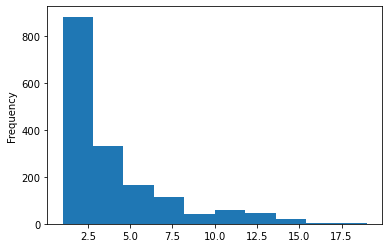

In [13]:
# Get a look at the distribution of seasons played by players
combined['Name'].value_counts().plot.hist()

Unsurprisingly, there is a **power law distribution** for seasons played. Only elite players have long lasting careers where most pitchers have very short stays in the major leagues.

This is a problem for my initial intended project of creating a time series-type predictor of player development of the course of their career. If a large number of players don't have length careers, then there isn't much to predict and if only a few players have long careers then there is too little data to power an accurate model.

Nevertheless, this data is still very detailed and can surely be used down the line.

In [213]:
# This was code to try and salvage the data for my initial project by filtering out and keeping only players with 4+ years
# Since I changed project goals, this is no longer needed
#combined = combined.groupby('Name').filter(lambda x : len(x)>3)

In [17]:
# Encode season (ie. year) as an integer to save some memory
combined['Season'] = combined['Season'].astype('int')

In [18]:
# Drop all years prior to 2002
combined.drop(combined[combined['Season'] < 2002].index, inplace = True)

Looking at the data showed that advanced statistics such as ground ball % and pitch usage %s were only available **after 2002**. This was either the time when MLB implemented advanced statistics or as far back as Fangraphs has gone through game film to provide these statistics.

Without these statistics, my downstream goals can't be achieved as these advanced stats are required. 

Since I plan to create a pitch predictor, it will aim to support active pitchers and since pitchers that have played prior to 2002 are most likely retired, my project will not be useful in predicting what retired pitchers will throw. 

So I decided that dropping entries from before 2002 will not impact my project.

***

In [19]:
# Check for nulls at this point
combined.isna().sum()

Season         0
Name           0
Team           0
W              0
L              0
SV             0
G              0
GS             0
IP             0
K/9            0
BB/9           0
HR/9           0
BABIP          0
LOB%           0
GB%            0
HR/FB          0
ERA            0
FIP            0
xFIP           0
WAR            0
Age            0
HBP            0
LD%            0
FlyBall%       0
FB%            8
SL%         1196
CT%         3869
CB%          911
CH%          319
SF%         4778
KN%         5415
FBv           26
AVG            0
WHIP           0
dtype: int64

The NaNs appear primarily in the pitch % usage columns. This is almost certainly corresponding to a 0 value where a pitcher does not throw that particular pitch. This is reflected in the high number of NaNs for knuckleballs, cutters and split-finger fastballs, all relatively uncommon pitches, and the extremely low number for fastballs, an ubiquitous pitch.

However, there are still nulls for fastball use %, even though every pitcher that I know, including pure knuckleballers, have thrown fastballs at some point during the season. This requires further investigation.

In [21]:
# It seems weird that pitchers would have thrown no fastballs
# Look at rows where these NaNs appear
combined[combined['FB%'].isna()]

,Season,Name,Team,W,L,SV,G,GS,IP,K/9,...,FB%,SL%,CT%,CB%,CH%,SF%,KN%,FBv,AVG,WHIP
1272,2005,Clay Hensley,Padres,0,1,0,1,1,5.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.211,1.20
1396,2002,Cory Vance,Rockies,0,0,0,1,1,3.0,3.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.111,1.33
3026,2004,Joe Valentine,Reds,0,1,0,1,1,1.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.400,7.00
3298,2004,Jorge DePaula,Yankees,0,1,0,1,1,6.1,1.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.308,1.42
3612,2004,Kevin Correia,Giants,0,0,0,1,1,2.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.462,4.50
4133,2005,Matt Kinney,Giants,0,0,0,1,1,2.1,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.533,3.86
5430,2005,Tanyon Sturtze,Yankees,0,0,0,1,1,3.2,2.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.214,1.64
5535,2003,Todd Jones,Rockies,0,1,0,1,1,4.1,4.15,...,NaN,NaN,NaN,20.3%,79.7%,NaN,NaN,NaN,.429,2.08


It looks like the rows that correspond to NaNs in fastball percentage have NaN's in largely ALL pitch type columns, and corresponds to missing data rather than a 0. I'll elect to drop these rows.

One pitcher, Todd Jones, a closer, interestingly seems to be a genuine case of only throwing changeups and curveballs, and no fastballs at all. I've never seen this in action but looking at his stats, he did not perform too well (batters hit over 0.400 against him, YIKES). I decided to drop this entry as well for simplicity sake since he only pitcher 4 and 1/3 innings in that year, which is barely anything in baseball time.

In [23]:
# Drop entries with nulls in fastball % and fastball velocity
combined.drop(combined[combined['FB%'].isna()].index, inplace = True)
# Fastball velocity is required for downstream analysis
combined.drop(combined[combined['FBv'].isna()].index, inplace = True)

In [24]:
# The remaining NaNs can then be filled with 0s since they correspond to a 0 value for pitch usage
combined.fillna(0, inplace = True)

In [25]:
# All NaN's filled
combined.isna().sum()

Season      0
Name        0
Team        0
W           0
L           0
SV          0
G           0
GS          0
IP          0
K/9         0
BB/9        0
HR/9        0
BABIP       0
LOB%        0
GB%         0
HR/FB       0
ERA         0
FIP         0
xFIP        0
WAR         0
Age         0
HBP         0
LD%         0
FlyBall%    0
FB%         0
SL%         0
CT%         0
CB%         0
CH%         0
SF%         0
KN%         0
FBv         0
AVG         0
WHIP        0
dtype: int64

In [26]:
# Reset index since rows were dropped
combined.reset_index(drop = True, inplace = True)

In [27]:
# Check data types
combined.dtypes

Season       int32
Name        object
Team        object
W           object
L           object
SV          object
G           object
GS          object
IP          object
K/9         object
BB/9        object
HR/9        object
BABIP       object
LOB%        object
GB%         object
HR/FB       object
ERA         object
FIP         object
xFIP        object
WAR         object
Age         object
HBP         object
LD%         object
FlyBall%    object
FB%         object
SL%         object
CT%         object
CB%         object
CH%         object
SF%         object
KN%         object
FBv         object
AVG         object
WHIP        object
dtype: object

Almost ALL columns are encoded as strings even though most are truly numeric. This will need to be addressed before the data can be used.

One thing right off the bat to note is that before we can turn all the columns numeric, some columns have a percent sign corresponding to a percentage. This will need to be stripped.

In [28]:
# Strip % signs from all columns
for column in combined.columns[1:]:
    combined[column] = combined[column].str.strip('%')

In [29]:
# All columns after the 3rd one (Team), are numeric
# Can then iteratre over all columns and apply the pd.to_numeric function to them
for colname in combined.columns[2:]:
    combined[colname] = pd.to_numeric(combined[colname], errors = 'coerce')

In [30]:
# All columns to their appropriate types now
combined.dtypes

Season        int32
Name         object
Team        float64
W             int64
L             int64
SV            int64
G             int64
GS            int64
IP          float64
K/9         float64
BB/9        float64
HR/9        float64
BABIP       float64
LOB%        float64
GB%         float64
HR/FB       float64
ERA         float64
FIP         float64
xFIP        float64
WAR         float64
Age           int64
HBP           int64
LD%         float64
FlyBall%    float64
FB%         float64
SL%         float64
CT%         float64
CB%         float64
CH%         float64
SF%         float64
KN%         float64
FBv         float64
AVG         float64
WHIP        float64
dtype: object

In [49]:
# Create a column that calculates the innings pitcher per game for a pitcher over a season
# Will round to 2 decimal places
combined['IP/G']  = round((np.floor(combined['IP']) + ((combined['IP'] - (np.floor(combined['IP'])))/0.3))
                           /combined['GS'], 2)
combined['IP/G']

0       6.95
1       5.75
2       6.21
3       6.53
4       6.46
        ... 
5437    5.08
5438    6.29
5439    6.30
5440    3.50
5441    5.33
Name: IP/G, Length: 5442, dtype: float64

A further explanation on the math behind calculating `IP/G`.

Innings are calculated on an out basis. Each inning in baseball has 3 outs. If a pitcher gets 3 outs, he will be consider to have pitched a full inning.

In the case a pitcher throws 4 innings for example, but does not get the full 3 outs in the 5th but instead gets 1 or 2 outs before leaving the game, he is then credited with 4 and a third/two-thirds of an inning pitched. 

Mathematically, this would be denoated as $4.33$ or $4.67$ innings pitched.

**BUT** in baseball, this statistical is denoted as $4.1$ or $4.2$ innings pitched. And a full 5 innings would be denoted as $5.0$. This difference in baseball stats and regular math makes it difficult to work with innings pitched data.

To get around this in order to calculate innings pitched/game:

1. I took the whole number of innings using np.floor (always round down to the last whole number)
2. I then subtracted the full number from the whole number to get the 'remainder outs'
3. Using the remainder outs, I divided them by 0.3 to get a proportion that reflects either 1/3 or 2/3 of a whole
4. I added that back to the whole number to now get a mathematically correct representation of the number of innings pitched
(ie. 200.667 instead of 200.2)
5. Using that number, I can then divide by the number of games started `GS` to get the average innings pitched per game

**NOTE:** Because the scope of my project is going to focusing on **starting pitchers** I went with the `GS` column, representing GAMES STARTED rather than the `G` column, which represents total games appeared in. The `G` column includes games where the pitcher may have made relief appearances in the middle/end of game. 

These relief appearances are shorter by nature and can be multiple over the course of a season, and therefore, will skew the `IP/G` data for pitchers that have appeared as a non-starter to be lower.

I also acknowledge that this way, I am skewing the data for those that have relief appearances (ie. more games than games started) to have higher `IP/G` than those that do not, but given that relief appearances are short and rare by nature for starting pitchers, this will have a less significant impact. 

In practical terms, adding 5 innings pitched to a starting pitcher who typically throws 150-200 innings/season will have less impact on `IP/G` than increasing the denominator (ie. games), which is usually in the 20s, by 1-3.

***

In [80]:
# I realized that calculating percentile this way would be calculating their percentile across ALL seasons
# This would be a VERY poor way to do so!
# I later used this same code but with alterations to calculate percentile on a season basis

# K_ptile = []
# BB_ptile = []
# IPG_ptile = []
# BABIP_ptile = []
# FBv_ptile = []
# GB_ptile = []
# for i in range(len(combined)):
#     K_ptile.append(percentileofscore(combined['K/9'], combined.loc[i,'K/9']))
#     BB_ptile.append(100 - (percentileofscore(combined['BB/9'], combined.loc[i,'BB/9'])))
#     IPG_ptile.append(percentileofscore(combined['IP/G'], combined.loc[i,'IP/G']))
#     BABIP_ptile.append(100-(percentileofscore(combined['BABIP'], combined.loc[i,'BABIP'])))
#     FBv_ptile.append(percentileofscore(combined['FBv'], combined.loc[i,'FBv']))
#     GB_ptile.append(percentileofscore(combined['GB%'], combined.loc[i,'GB%']))
# combined['Strikeouts'] = K_ptile
# combined['Control'] = BB_ptile
# combined['Stamina/Consistency']= IPG_ptile
# combined['BA Against'] = BABIP_ptile
# combined['Velocity'] = FBv_ptile
# combined['Ground Balls'] = GB_ptile

C:\ProgramData\Anaconda\lib\site-packages\scipy\stats\stats.py:1857: RuntimeWarning: invalid value encountered in less
  left = np.count_nonzero(a < score)
C:\ProgramData\Anaconda\lib\site-packages\scipy\stats\stats.py:1858: RuntimeWarning: invalid value encountered in less_equal
  right = np.count_nonzero(a <= score)
C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

I wanted to create a measure of a pitcher's pitch usage diversity. Intuitively, a more diverse pitcher will be harder to hit as they are more unpredictable and have many more types of pitches that a batter has to prepare for.

There is however no publicly available data on a pitcher's pitch diversity. I did some research in how diversity is calculated in other fields and discovered the concept and equation of **Shannon's Diversity Index** an ecology based metric to measure the diversity of a natural biome.

Although baseball and ecology are very different, from looking at the equation, it can be used for my purpose as well. The equation factors in the number of different species (ie. pitches) as well as the proportional frequency of those species (ie. proportional pitch usage).

Shannon's Diversity Index is defined by the equation below:

![Shannon Index](https://puu.sh/G0BPz/35400f6a6e.png)

Where $s$ is the number of species and $p$ is the frequency of the specie.

In [52]:
# Diversity is based off of Shannon's Diversity Index: H = -sum(pi * ln(pi))
# Create a dataframe of just the pitch percentages -> makes it easier to work with
# There will be some ln0 situations (pitcher does not use a pitch) but the code coerces it without trouble
pitchdf = pd.DataFrame(
    ((combined.loc[:,'FB%':'KN%']/100).loc[:,:]*np.log((combined.loc[:,'FB%':'KN%']/100).loc[:,:])).fillna(0))
pitchdf['diversity'] = pitchdf.sum(axis=1)*(-1)
pitchdf

<ipython-input-52-44f8b5ef28a2>:5: RuntimeWarning: divide by zero encountered in log
  ((combined.loc[:,'FB%':'KN%']/100).loc[:,:]*np.log((combined.loc[:,'FB%':'KN%']/100).loc[:,:])).fillna(0))


,FB%,SL%,CT%,CB%,CH%,SF%,KN%,diversity
0,-0.252234,0.000000,0.0,-0.347338,-0.153739,0.000000,0.0,0.753311
1,-0.223516,-0.046052,0.0,-0.304274,-0.198982,0.000000,0.0,0.772823
2,-0.235851,-0.117334,0.0,-0.321888,-0.137437,0.000000,0.0,0.812509
3,-0.287826,-0.017427,0.0,-0.350926,-0.228951,0.000000,0.0,0.885130
4,-0.268320,0.000000,0.0,-0.358501,-0.133144,0.000000,0.0,0.759964
...,...,...,...,...,...,...,...,...
5437,-0.297423,-0.323096,0.0,-0.270335,-0.141639,0.000000,0.0,1.032493
5438,-0.315028,-0.316850,0.0,-0.236648,-0.133144,-0.198982,0.0,1.200651
5439,-0.311303,-0.321888,0.0,-0.228951,-0.210993,-0.089513,0.0,1.162648
5440,-0.271890,-0.323694,0.0,-0.232844,-0.107687,0.000000,0.0,0.936114


In [53]:
# Take that diversity column from the pitches only data frame and copy it over the the main dataframe
combined['Shannon Diversity'] = pitchdf['diversity'].copy()

In [54]:
combined

,Season,Name,Team,W,L,SV,G,GS,IP,K/9,...,CT%,CB%,CH%,SF%,KN%,FBv,AVG,WHIP,IP/G,Shannon Diversity
0,2002,A.J. Burnett,NaN,12,9,0,29,29,201.2,8.70,...,NaN,25.2,5.2,NaN,NaN,94.4,0.202,1.17,6.95,0.753311
1,2003,A.J. Burnett,NaN,0,2,0,4,4,23.0,8.22,...,NaN,17.4,7.8,NaN,NaN,92.8,0.209,1.57,5.75,0.772823
2,2004,A.J. Burnett,NaN,7,6,0,19,19,118.0,8.31,...,NaN,20.0,4.4,NaN,NaN,95.4,0.229,1.18,6.21,0.812509
3,2005,A.J. Burnett,NaN,12,12,0,32,32,209.0,8.53,...,NaN,26.2,9.9,NaN,NaN,95.6,0.234,1.26,6.53,0.885130
4,2006,A.J. Burnett,NaN,10,8,0,21,21,135.2,7.83,...,NaN,28.8,4.2,NaN,NaN,94.9,0.260,1.30,6.46,0.759964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5437,2017,Zack Wheeler,NaN,3,7,0,17,17,86.1,8.44,...,NaN,13.5,4.6,NaN,NaN,94.6,0.283,1.59,5.08,1.032493
5438,2018,Zack Wheeler,NaN,12,7,0,29,29,182.1,8.84,...,NaN,10.5,4.2,7.8,NaN,95.9,0.221,1.12,6.29,1.200651
5439,2019,Zack Wheeler,NaN,11,8,0,31,31,195.1,8.98,...,NaN,9.9,8.6,2.4,NaN,96.7,0.253,1.26,6.30,1.162648
5440,2013,Zeke Spruill,NaN,0,2,0,2,2,7.0,5.14,...,NaN,10.2,3.1,NaN,NaN,90.6,0.394,2.14,3.50,0.936114


Strangely enough NaN's have appeared again the the pitch % columns as well as the `Team` column.
However, I am not concerned with these at this point because the `Team` column is of no interest to me and I will most likely either ignore or discard it. 

The pitch % columns are also not an issue as I've extract the necessary information from these columns in creating the `Shannon Diversity` column. I'll leave these here as is for now and will deal with them on a need-to basis down the line.

In [237]:
# Save
#combined.to_csv('combined_cleaned.csv')

***

I wanted to get a feel for how pitcher's traits changed over the course of their careers and visualize it on a radar plot. There are a couple challenges in doing that:

1. The traits I'm looking at are on different scales (ie. IP/G, diversity, strikeouts...). A radar plot requires all features to be on the same scale
2. I want to calculate it on a season by season basis

In [56]:
# Create a list of empty dataframes
year_dfs = []
# Iterate over a list of each unique season
for year in pd.unique(combined['Season']):
    # Append the dataframe for each unique season to the list of dataframes
    year_dfs.append(combined[combined['Season'] == year])

In [58]:
# Check to see if it worked, the first list entity should only have entries from 2002
display(year_dfs[0])
print('')
print(year_dfs[0]['Season'].value_counts())

,Season,Name,Team,W,L,SV,G,GS,IP,K/9,...,CT%,CB%,CH%,SF%,KN%,FBv,AVG,WHIP,IP/G,Shannon Diversity
0,2002,A.J. Burnett,NaN,12,9,0,29,29,201.2,8.70,...,NaN,25.2,5.2,NaN,NaN,94.4,0.202,1.17,6.95,0.753311
30,2002,Aaron Cook,NaN,2,1,0,5,5,30.0,3.60,...,NaN,NaN,6.1,NaN,NaN,92.3,0.308,1.57,6.00,0.819481
42,2002,Aaron Harang,NaN,5,3,0,15,15,76.1,7.43,...,NaN,NaN,9.6,0.1,NaN,84.0,0.254,1.55,5.09,0.745803
65,2002,Aaron Myette,NaN,2,5,0,12,12,45.1,9.13,...,NaN,NaN,11.2,NaN,NaN,92.2,0.317,2.16,3.78,0.872776
76,2002,Aaron Sele,NaN,8,9,0,26,26,160.0,4.61,...,NaN,31.8,8.5,NaN,NaN,85.4,0.292,1.49,6.15,1.069896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5268,2002,Wayne Franklin,NaN,2,1,0,4,4,24.0,6.38,...,NaN,NaN,14.8,NaN,NaN,88.0,0.186,1.38,6.00,0.754531
5278,2002,Wes Obermueller,NaN,0,2,0,2,2,7.2,5.87,...,NaN,NaN,14.5,NaN,NaN,88.3,0.378,2.09,3.83,0.837589
5299,2002,Wilson Alvarez,NaN,2,2,0,10,10,47.0,5.94,...,NaN,16.3,10.2,NaN,NaN,86.3,0.289,1.68,4.70,0.754822
5310,2002,Woody Williams,NaN,9,4,0,17,17,103.1,6.62,...,NaN,17.1,8.3,NaN,NaN,88.0,0.219,1.05,6.08,0.845891



2002    304
Name: Season, dtype: int64


***
Recall the 2 issues that I have:

1. The traits I'm looking at are on different scales (ie. IP/G, diversity, strikeouts...). A radar plot requires all features to be on the same scale
2. I want to calculate it on a season by season basis

To address these I aim to:

1. Standardize these traits by calculating them as a percentile across all players
2. Calculate the percentiles on a season-by-season basis

There are 7 traits of interest to me (refined to 6 later on):

1. **Strikeouts**, measured through the number of strikeouts (K) per 9 innings (a full game) > `K/9`
2. **Control**, measured through the number of walks/base on balls (BB) per 9 innings (a full game) > `BB/9`
3. **Stamina**, measured through their innings pitched per game > `IP/G`
4. **Velocity**, measured through their average fastball velocity > `FBv`
5. **Pitch Diversity**, measured through their `Shannon Diversity`
6. **Ability to Induce Ground Balls**, measured through their ground ball percentage (ie. number of balls in play that results in a ground ball) > `GB%`
7. **Opponent batting average**, measured through their opponent batting average for balls in play which intends to measure how well do batters hit their pitches when they do make contact > `BABIP`

I find these traits to be "inherent" pitching traits, meaning they reflect a pitcher's true style and internal tendencies with minimal influence from external factors such as luck.

In [60]:
# Loop through each dataframe for each year
for year_df in year_dfs:
    year_df.reset_index(drop = True, inplace = True)
    # Create empty lists to store the values for each percentile trait I'm calculating
    K_ptile = []
    BB_ptile = []
    IPG_ptile = []
    BABIP_ptile = []
    FBv_ptile = []
    GB_ptile = []
    div_ptile = []
    
    # Loop through each entry and calculate its percentile and append to list
    for i in range(len(year_df)):     
        K_ptile.append(percentileofscore(year_df['K/9'], year_df.loc[i,'K/9']))
        BB_ptile.append(100 - (percentileofscore(year_df['BB/9'], year_df.loc[i,'BB/9'])))
        IPG_ptile.append(percentileofscore(year_df['IP/G'], year_df.loc[i,'IP/G']))
        BABIP_ptile.append(100-(percentileofscore(year_df['BABIP'], year_df.loc[i,'BABIP'])))
        FBv_ptile.append(percentileofscore(year_df['FBv'], year_df.loc[i,'FBv']))
        GB_ptile.append(percentileofscore(year_df['GB%'], year_df.loc[i,'GB%']))
        div_ptile.append(percentileofscore(year_df['Shannon Diversity'], year_df.loc[i,'Shannon Diversity']))
        
    # Create new columns with these percentile lists as values
    year_df['Strikeouts'] = K_ptile
    year_df['Control'] = BB_ptile
    year_df['Stamina/Consistency']= IPG_ptile
    year_df['BA Against'] = BABIP_ptile
    year_df['Velocity'] = FBv_ptile
    year_df['Ground Balls'] = GB_ptile
    year_df['Pitch Diversity'] = div_ptile

<ipython-input-60-8fcd6f9fd78c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df['Strikeouts'] = K_ptile


In [61]:
# Create a final dataframe
final = pd.DataFrame()
# Loop through each season's dataframe and append it to the list
for year_df in year_dfs:
    final = pd.concat([final, year_df], sort = False)

In [62]:
# Want entries sorted by name and then season
final.sort_values(by=['Name','Season'], inplace = True)

final.reset_index(drop = True, inplace = True)

In [63]:
final

,Season,Name,Team,W,L,SV,G,GS,IP,K/9,...,WHIP,IP/G,Shannon Diversity,Strikeouts,Control,Stamina/Consistency,BA Against,Velocity,Ground Balls,Pitch Diversity
0,2002,A.J. Burnett,NaN,12,9,0,29,29,201.2,8.70,...,1.17,6.95,0.753311,90.789474,36.348684,97.203947,88.322368,100.000000,57.236842,15.460526
1,2003,A.J. Burnett,NaN,0,2,0,4,4,23.0,8.22,...,1.57,5.75,0.772823,91.118421,6.250000,61.019737,85.032895,97.861842,89.144737,7.894737
2,2004,A.J. Burnett,NaN,7,6,0,19,19,118.0,8.31,...,1.18,6.21,0.812509,89.455782,66.666667,83.333333,64.115646,100.000000,81.122449,10.884354
3,2005,A.J. Burnett,NaN,12,12,0,32,32,209.0,8.53,...,1.26,6.53,0.885130,92.395437,38.022814,87.452471,41.825095,99.239544,95.057034,20.152091
4,2006,A.J. Burnett,NaN,10,8,0,21,21,135.2,7.83,...,1.30,6.46,0.759964,83.222591,74.418605,89.700997,39.368771,98.671096,85.215947,6.976744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5437,2017,Zack Wheeler,NaN,3,7,0,17,17,86.1,8.44,...,1.59,5.08,1.032493,70.793651,22.857143,39.523810,23.174603,87.777778,72.857143,41.904762
5438,2018,Zack Wheeler,NaN,12,7,0,29,29,182.1,8.84,...,1.12,6.29,1.200651,67.201166,65.597668,98.250729,69.241983,95.335277,57.871720,77.259475
5439,2019,Zack Wheeler,NaN,11,8,0,31,31,195.1,8.98,...,1.26,6.30,1.162648,62.228261,76.902174,97.146739,41.711957,96.603261,57.608696,69.021739
5440,2013,Zeke Spruill,NaN,0,2,0,2,2,7.0,5.14,...,2.14,3.50,0.936114,19.087838,65.033784,5.236486,8.277027,44.425676,45.945946,25.675676


In [64]:
# Save to .csv
# final.to_csv('Master_df.csv')

In [65]:
# Making sure it looks good in terms of a specific player
final[final['Name']=='Felix Hernandez']

,Season,Name,Team,W,L,SV,G,GS,IP,K/9,...,WHIP,IP/G,Shannon Diversity,Strikeouts,Control,Stamina/Consistency,BA Against,Velocity,Ground Balls,Pitch Diversity
1837,2005,Felix Hernandez,NaN,4,4,0,12,12,84.1,8.22,...,1.00,7.03,1.033015,88.212928,71.482890,98.098859,88.022814,99.619772,99.239544,53.612167
1838,2006,Felix Hernandez,NaN,12,14,0,31,31,191.0,8.29,...,1.34,6.16,1.118802,89.534884,66.777409,79.235880,39.368771,99.335548,93.355482,71.096346
1839,2007,Felix Hernandez,NaN,14,7,0,30,30,190.1,7.80,...,1.38,6.34,1.134238,85.215947,75.913621,90.033223,22.757475,99.667774,96.677741,75.083056
1840,2008,Felix Hernandez,NaN,9,11,0,31,31,200.2,7.85,...,1.39,6.47,1.010428,80.263158,41.447368,94.078947,34.210526,98.684211,88.815789,58.881579
1841,2009,Felix Hernandez,NaN,19,5,0,34,34,238.2,8.18,...,1.14,7.02,1.060986,83.823529,76.633987,99.346405,73.529412,95.261438,92.156863,58.823529
1842,2010,Felix Hernandez,NaN,13,12,0,34,34,249.2,8.36,...,1.06,7.34,1.097712,82.600733,73.809524,99.267399,82.967033,97.069597,91.391941,60.073260
1843,2011,Felix Hernandez,NaN,14,14,0,33,33,233.2,8.55,...,1.22,7.08,1.176938,88.419118,64.705882,97.426471,35.294118,88.970588,80.698529,74.632353
1844,2012,Felix Hernandez,NaN,13,9,0,33,33,232.0,8.65,...,1.14,7.03,1.165229,82.517483,78.846154,98.776224,36.013986,71.853147,72.727273,70.979021
1845,2013,Felix Hernandez,NaN,12,10,0,31,31,204.1,9.51,...,1.13,6.59,1.175099,93.581081,84.459459,95.270270,34.121622,67.567568,83.108108,76.689189
1846,2014,Felix Hernandez,NaN,15,6,0,34,34,236.0,9.46,...,0.92,6.94,1.228602,92.560554,87.024221,98.615917,88.581315,75.086505,92.906574,87.197232


***